### Loading libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

from tqdm.notebook import tqdm
from scipy.signal import correlate
from statsmodels.graphics.tsaplots import plot_acf
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Loading data

In [3]:
close = pd.read_csv('close.csv', index_col='time')
close.index = pd.to_datetime(close.index)
close.ffill(inplace=True)

open = pd.read_csv('open.csv', index_col='time')
open.index = pd.to_datetime(open.index)
open.ffill(inplace=True)

high = pd.read_csv('high.csv', index_col='time')
high.index = pd.to_datetime(high.index)
high.ffill(inplace=True)

low = pd.read_csv('low.csv', index_col='time')
low.index = pd.to_datetime(low.index)
low.ffill(inplace=True)

value = pd.read_csv('value.csv', index_col='time')
value.index = pd.to_datetime(value.index)
value.ffill(inplace=True)

volume = pd.read_csv('volume.csv', index_col='time')
volume.index = pd.to_datetime(volume.index)
volume.ffill(inplace=True)

In [4]:
# close = pd.read_csv('data/hour/close.csv', index_col='Time')
# opens = pd.read_csv('data/hour/opens.csv', index_col='Time')
# high = pd.read_csv('data/hour/high.csv', index_col='Time')
# low = pd.read_csv('data/hour/low.csv', index_col='Time')
# volume = pd.read_csv('data/hour/volume.csv', index_col='Time')

# close_h = pd.read_csv('data/half/close_h.csv', index_col='Time')
# opens_h = pd.read_csv('data/half/open_h.csv', index_col='Time')
# high_h = pd.read_csv('data/half/high_h.csv', index_col='Time')
# low_h = pd.read_csv('data/half/low_h.csv', index_col='Time')
# volume_h = pd.read_csv('data/half/volume_h.csv', index_col='Time')

In [5]:
data = {
  'close': close,
  'opens': open,
  'high': high,
  'low': low,
  'value': value,
  'volume': volume
}

# half_data = {
#   'close_h': close_h,
#   'opens_h': opens_h,
#   'high_h': high_h,
#   'low_h': low_h,
#   'volume_h': volume_h,
# }

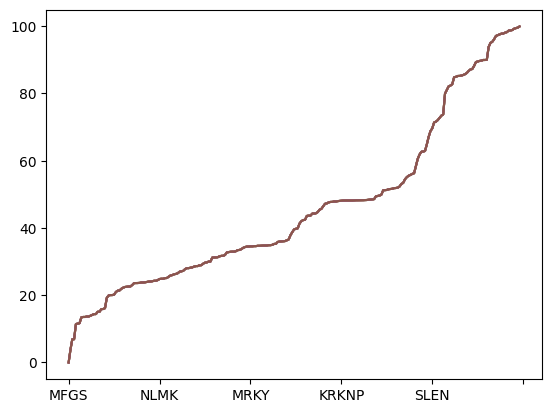

In [6]:
for df in data:
  missing_values = data[df]
  missing_values = close.isnull().sum()
  missing_percent = missing_values / len(close) * 100
  missing_percent.sort_values().plot()
plt.show()

# for df in half_data:
#   missing_values = half_data[df]
#   missing_values = close.isnull().sum()
#   missing_percent = missing_values / len(close) * 100
#   missing_percent.sort_values().plot()
# plt.show()

In [7]:
good_columns = close.ffill().interpolate(method='linear').isna().sum()[close.ffill().interpolate(method='linear').isna().sum() < 2000].index

In [8]:
close = close[good_columns].ffill().interpolate(method='linear').dropna()
open = open[good_columns].ffill().interpolate(method='linear').dropna()
high = high[good_columns].ffill().interpolate(method='linear').dropna()
low = low[good_columns].ffill().interpolate(method='linear').dropna()
volume = volume[good_columns].ffill().interpolate(method='linear').dropna()

returns = close.pct_change().dropna()

close.columns = [f'close_{col}' for col in close.columns]
open.columns = [f'open_{col}' for col in open.columns]
high.columns = [f'high_{col}' for col in high.columns]
low.columns = [f'low_{col}' for col in low.columns]
volume.columns = [f'volume_{col}' for col in volume.columns]

In [9]:
returns = close.pct_change().dropna()

In [10]:
training_data = pd.concat([
  close,
  open,
  high,
  low,
  volume
], axis=1)

In [11]:
all_x, all_y = [], []

for i in tqdm(range(len(training_data) - 52)):
  try:
    all_x.append(training_data.iloc[i:i+50].values)
    all_y.append(training_data.iloc[:,0].pct_change().shift().ffill().dropna()[i+50])
  except:
    pass

  0%|          | 0/3982 [00:00<?, ?it/s]

C:\Users\ciell\AppData\Local\Temp\ipykernel_17988\344586861.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_y.append(training_data.iloc[:,0].pct_change().shift().ffill().dropna()[i+50])


In [12]:
len(all_x), len(all_y)

(3982, 3982)

In [13]:
all_x = np.array(all_x)
all_y = np.array(all_y)

In [14]:
# x = training_data.iloc[1:-1].values
# y = training_data.iloc[:,0].pct_change().shift().dropna().values

x, x_final = all_x[:-100], all_x[-100:]
y, y_final = all_y[:-100], all_y[-100:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [15]:
x_train.shape, y_train.shape

((3105, 50, 465), (3105,))

In [16]:
x_train = torch.Tensor(x_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.Tensor(x_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

x_final = torch.Tensor(x_final)
y_final = torch.tensor(y_final, dtype=torch.float32)

print("Shape of x_train:", x_train.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_train.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_test.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_final.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_final.shape)  # Ожидаемая форма: (3107,)

Shape of x_train: torch.Size([3105, 50, 465])
Shape of y_train: torch.Size([3105])
Shape of x_train: torch.Size([777, 50, 465])
Shape of y_train: torch.Size([777])
Shape of x_train: torch.Size([100, 50, 465])
Shape of y_train: torch.Size([100])


In [17]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

x_final = x_final.to(device)
y_final = y_final.to(device)

### Making ML models

#### Simple single LSTM

In [33]:
# Создание простой модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Используем последнее значение из последовательности
        return out

# Гиперпараметры
input_size = x_train.shape[2]  # Количество факторов (465)
hidden_size = 50  # Размер скрытого слоя
output_size = 1  # Одно выходное значение
learning_rate = 0.0001
num_epochs = 5000

In [34]:
class CombinedLoss(nn.Module):
  def __init__(self, alpha=0.5):
    super(CombinedLoss, self).__init__()
    self.alpha = alpha

  def forward(self, predictions, targets):
    mse_loss = torch.mean((predictions - targets) ** 2)
    mae_loss = torch.mean(torch.abs(predictions - targets))
    loss = self.alpha * mse_loss + (1 - self.alpha) * mae_loss
    return loss

# Использование комбинированной функции потерь
combined_loss = CombinedLoss(alpha=0.7)

class SharpeLoss(nn.Module):
  def __init__(self, alpha=0.5):
    super(SharpeLoss, self).__init__()
    # self.alpha = alpha

  def forward(self, predictions, targets):
    alpha = torch.where(predictions > 0, 1, -1)
    alpha = alpha.float().requires_grad_()
    targets = targets.float().requires_grad_()
    sharpe = (alpha * targets).sum() / (alpha * targets).std()
    loss = abs(1 / sharpe)
    return loss

class SharpeLossComissions(nn.Module):
    def __init__(self, alpha=0.5):
        super(SharpeLossComissions, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets):
        alpha = torch.where(predictions > 0, 1, -1)
        diff = torch.diff(alpha)
        abs_diff = torch.abs(diff)
        sum_changes = torch.sum(abs_diff)
        
        sharpe = ((alpha * targets).sum() - sum_changes * 0.0004) / (alpha * targets).std()
        loss = abs(1 / sharpe)
        return loss

# Использование комбинированной функции потерь
combined_loss = CombinedLoss(alpha=0.7)
sharpe_loss = SharpeLoss()
sharpe_loss2 = SharpeLossComissions()

Epoch [100/5000], Train Loss: 0.0304, Test Loss: 0.0319
Epoch [200/5000], Train Loss: 0.0276, Test Loss: 0.0292
Epoch [300/5000], Train Loss: 0.0252, Test Loss: 0.0268
Epoch [400/5000], Train Loss: 0.0229, Test Loss: 0.0245
Epoch [500/5000], Train Loss: 0.0207, Test Loss: 0.0223
Epoch [600/5000], Train Loss: 0.0187, Test Loss: 0.0203
Epoch [700/5000], Train Loss: 0.0169, Test Loss: 0.0185
Epoch [800/5000], Train Loss: 0.0153, Test Loss: 0.0169
Epoch [900/5000], Train Loss: 0.0138, Test Loss: 0.0154
Epoch [1000/5000], Train Loss: 0.0125, Test Loss: 0.0141
Epoch [1100/5000], Train Loss: 0.0113, Test Loss: 0.0130
Epoch [1200/5000], Train Loss: 0.0103, Test Loss: 0.0121
Epoch [1300/5000], Train Loss: 0.0095, Test Loss: 0.0113
Epoch [1400/5000], Train Loss: 0.0089, Test Loss: 0.0107
Epoch [1500/5000], Train Loss: 0.0085, Test Loss: 0.0103
Epoch [1600/5000], Train Loss: 0.0082, Test Loss: 0.0100
Epoch [1700/5000], Train Loss: 0.0080, Test Loss: 0.0098
Epoch [1800/5000], Train Loss: 0.0078, T

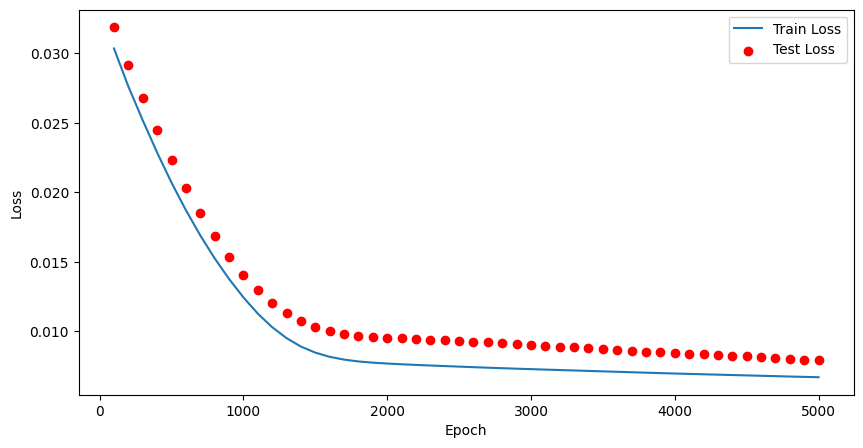

In [35]:
# Инициализация модели, функции потерь и оптимизатора
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Листы для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()
    y_pred = model(x_train).squeeze()
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_loss = loss.item()
            y_test_pred = model(x_test).squeeze()
            test_loss = criterion(y_test_pred, y_test).item()
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(range(100, num_epochs+1, 100), train_losses, label='Train Loss')
plt.scatter(range(100, num_epochs+1, 100), test_losses, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Пример предсказания
model.eval()
with torch.no_grad():
    test_predictions = model(x_test).squeeze().cpu().numpy()
    # print("Test Predictions:", test_predictions)

<Axes: >

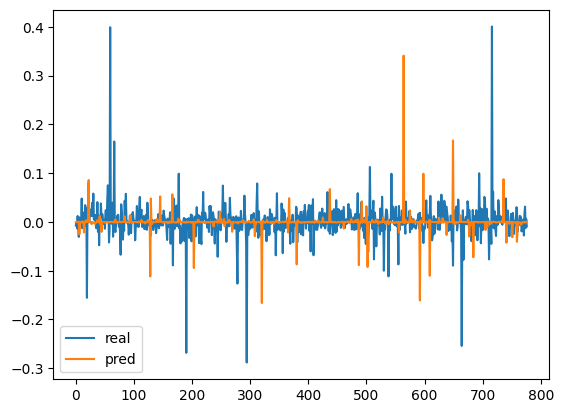

In [36]:
res = pd.concat([pd.DataFrame(y_test.detach().cpu().numpy(), columns=['real']), pd.DataFrame(test_predictions, columns=['pred'])], axis=1)
res.plot()

<Axes: >

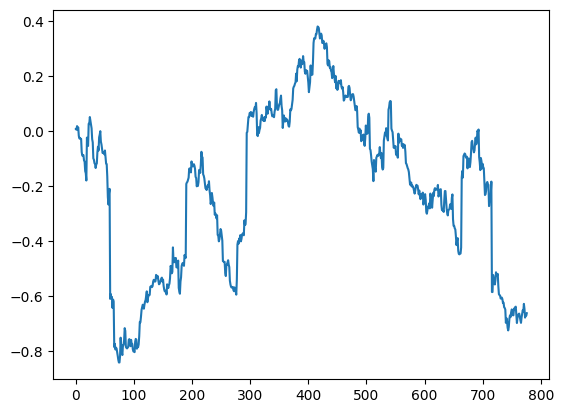

In [37]:
# res = pd.DataFrame({
#   'actual': actuals,
#   'pred': predictions.reshape(predictions.shape[0])
# }, index=training_data.index[-predictions.shape[0]:])

alpha = np.where(res['pred'] > 0, 1, -1)
(alpha * res['real']).cumsum().plot()

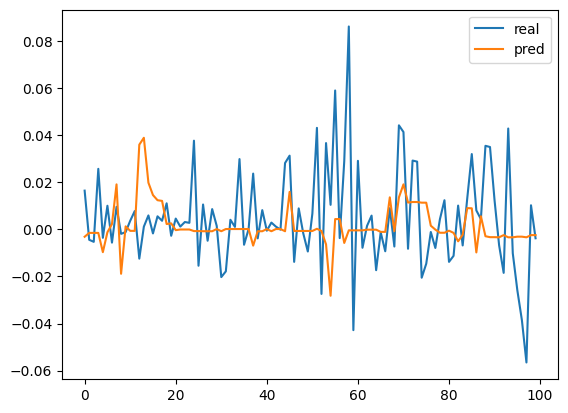

In [38]:
model.eval()
with torch.no_grad():
  final_predictions = model(x_final).squeeze().cpu().numpy()

res = pd.concat([pd.DataFrame(y_final.cpu().numpy(), columns=['real']), pd.DataFrame(final_predictions, columns=['pred'])], axis=1)
res.plot()
plt.show()

<Axes: >

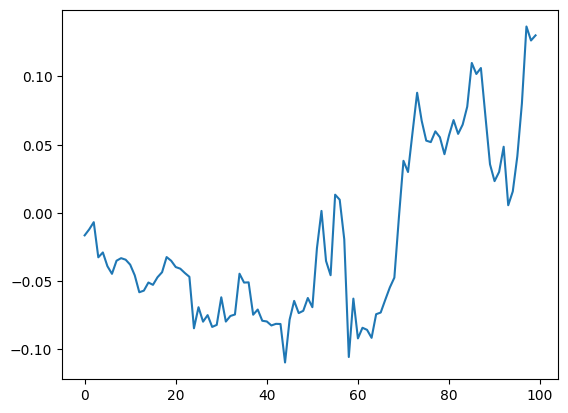

In [39]:
alpha = np.where(res['pred'] > 0, 1, -1)
(alpha * res['real']).cumsum().plot()

#### deep LSTM model

In [41]:
class DeepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DeepLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(self.dropout(lstm_out[:, -1, :]))  # Используем последнее значение из последовательности и применяем Dropout
        return out

# Гиперпараметры
input_size = x_train.shape[2]  # Количество факторов (465)
hidden_size = 50  # Размер скрытого слоя
num_layers = 5
output_size = 1  # Одно выходное значение
learning_rate = 0.0001
num_epochs = 1000

Epoch [100/1000], Train Loss: 0.0107, Test Loss: 0.0068
Epoch [200/1000], Train Loss: 0.0083, Test Loss: 0.0068
Epoch [300/1000], Train Loss: 0.0081, Test Loss: 0.0068
Epoch [400/1000], Train Loss: 0.0080, Test Loss: 0.0068
Epoch [500/1000], Train Loss: 0.0078, Test Loss: 0.0067
Epoch [600/1000], Train Loss: 0.0077, Test Loss: 0.0068
Epoch [700/1000], Train Loss: 0.0077, Test Loss: 0.0067
Epoch [800/1000], Train Loss: 0.0075, Test Loss: 0.0067
Epoch [900/1000], Train Loss: 0.0073, Test Loss: 0.0067
Epoch [1000/1000], Train Loss: 0.0072, Test Loss: 0.0067


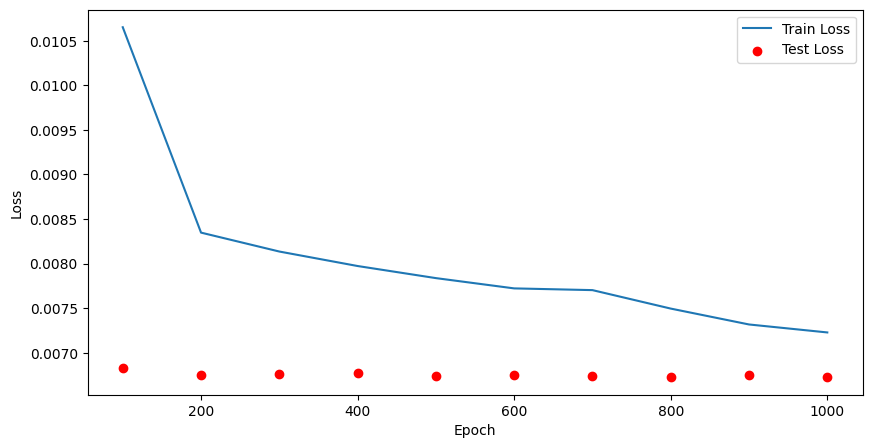

In [42]:
# Инициализация модели, функции потерь и оптимизатора
model = DeepLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Листы для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()
    y_pred = model(x_train).squeeze()
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_loss = loss.item()
            y_test_pred = model(x_test).squeeze()
            test_loss = criterion(y_test_pred, y_test).item()
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(range(100, num_epochs+1, 100), train_losses, label='Train Loss')
plt.scatter(range(100, num_epochs+1, 100), test_losses, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Пример предсказания
model.eval()
with torch.no_grad():
    test_predictions = model(x_test).squeeze().cpu().numpy()
    # print("Test Predictions:", test_predictions)

<Axes: >

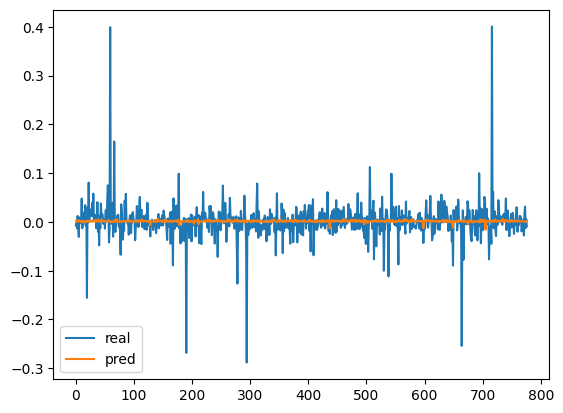

In [43]:
res = pd.concat([pd.DataFrame(y_test.detach().cpu().numpy(), columns=['real']), pd.DataFrame(test_predictions, columns=['pred'])], axis=1)
res.plot()

<Axes: >

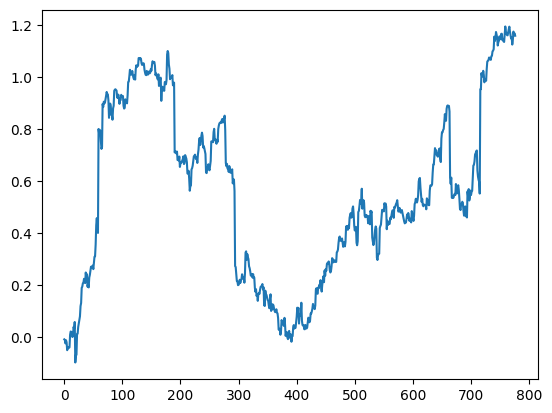

In [44]:
alpha = np.where(res['pred'] > 0, 1, -1)
(alpha * res['real']).cumsum().plot()

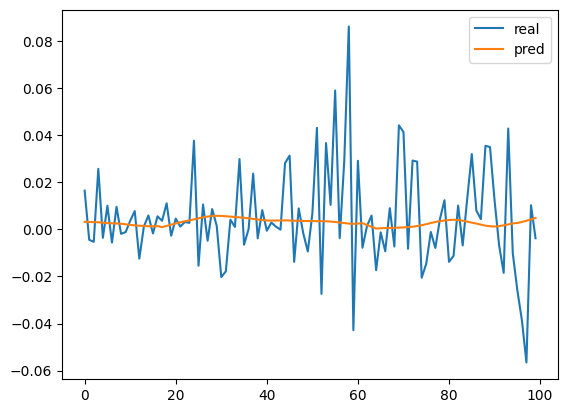

In [45]:
model.eval()
with torch.no_grad():
  final_predictions = model(x_final).squeeze().cpu().numpy()

res = pd.concat([pd.DataFrame(y_final.cpu().numpy(), columns=['real']), pd.DataFrame(final_predictions, columns=['pred'])], axis=1)
res.plot()
plt.show()

<Axes: >

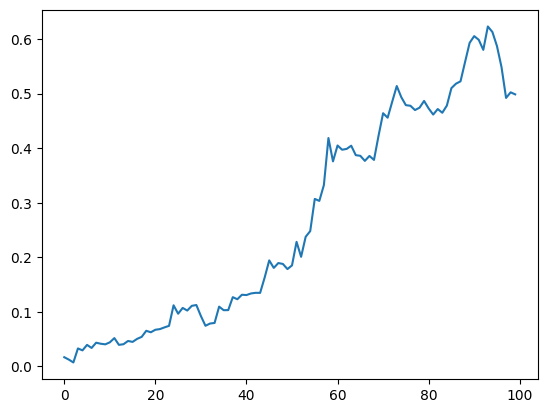

In [46]:
alpha = np.where(res['pred'] > 0, 1, -1)
(alpha * res['real']).cumsum().plot()